In [1]:
import pandas as pd
import numpy as np
import re
import time

import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

import folium
import folium.plugins as plugins

## Wczytanie i przegląd danych

In [2]:
df = pd.read_csv('./data/DataWorkshop.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229929 entries, 0 to 229928
Data columns (total 30 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Data zdarzenia                     229929 non-null  object 
 1   Godzina                            229929 non-null  object 
 2   GPS x                              229929 non-null  object 
 3   GPS y                              229929 non-null  object 
 4   Miejscowość                        229929 non-null  object 
 5   Ulica                              209201 non-null  object 
 6   Numer domu                         136045 non-null  object 
 7   Numer drogi                        229929 non-null  object 
 8   KM HM (Pikietaż)                   35041 non-null   object 
 9   Obszar                             229928 non-null  object 
 10  Skrzyżowanie                       63150 non-null   object 
 11  Geometria drogi                    1639

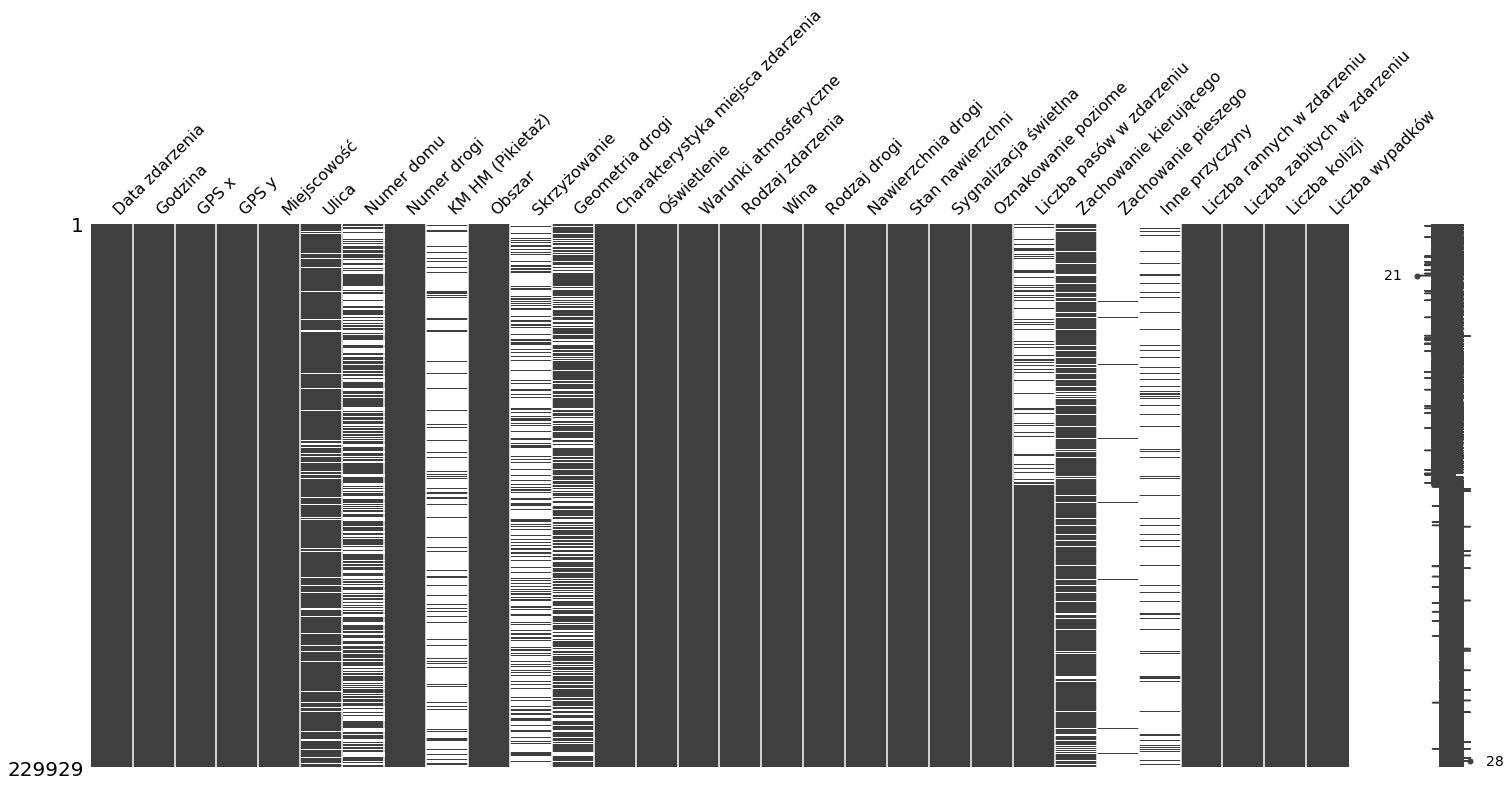

In [3]:
msno.matrix(df);

In [6]:
def check_missing():
    for column in df.columns:
        missing_items = df[column].isnull().sum()
        missing = column, missing_items, missing_items/df.shape[0]*100  
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

('Ulica', 20728, 9.014956791009398)
('Numer domu', 93884, 40.8317350138521)
('KM HM (Pikietaż)', 194888, 84.76007811106908)
('Obszar', 1, 0.0004349168656411327)
('Skrzyżowanie', 166779, 72.53499993476247)
('Geometria drogi', 66008, 28.707992467239883)
('Charakterystyka miejsca zdarzenia', 2, 0.0008698337312822654)
('Warunki atmosferyczne', 1, 0.0004349168656411327)
('Rodzaj drogi', 1, 0.0004349168656411327)
('Nawierzchnia drogi', 1, 0.0004349168656411327)
('Stan nawierzchni', 1, 0.0004349168656411327)
('Oznakowanie poziome', 2, 0.0008698337312822654)
('Liczba pasów w zdarzeniu', 88154, 38.33966137372841)
('Zachowanie kierującego', 27901, 12.134615468253243)
('Zachowanie pieszego', 227444, 98.91923158888179)
('Inne przyczyny', 203726, 88.6038733696054)


In [4]:
df.shape[0]

229929

In [5]:
df.sample(3)

,Data zdarzenia,Godzina,GPS x,GPS y,Miejscowość,Ulica,Numer domu,Numer drogi,KM HM (Pikietaż),Obszar,...,Sygnalizacja świetlna,Oznakowanie poziome,Liczba pasów w zdarzeniu,Zachowanie kierującego,Zachowanie pieszego,Inne przyczyny,Liczba rannych w zdarzeniu,Liczba zabitych w zdarzeniu,Liczba kolizji,Liczba wypadków
66526,2017-04-05,07:00:00,19*01'100,50*07'172,TYCHY,BESKIDZKA,NaN,K1E,"0,9",Obszar niezabudowany,...,Brak,Jest,NaN,Nieprawidłowe zmienianie pasa ruchu,NaN,NaN,0,0,1,0
476,2016-01-09,08:20:00,19*13'397,50*20'400,DĄBROWA GÓRNICZA,PARKOWA,NaN,G200 128S,NaN,Obszar zabudowany,...,"Jest, działa",Nie ma,NaN,Niestosowanie się do sygnalizacji świetlnej (o...,NaN,NaN,0,0,1,0
217031,2019-10-19,16:00:00,18*48'548,50*19'044,ZABRZE,BYTOMSKA,NIEZNANE,P8207S,NaN,Obszar zabudowany,...,Brak,Jest,2.0,Niezachowanie bezp. odleg. między pojazdami,NaN,NaN,0,0,1,0


## Porządkowanie danych

In [6]:
# rename columns
def remove_accents(input_text):
    strange='ąćęłńóśźż'
    ascii_replacements='acelnoszz'
    translator=str.maketrans(strange,ascii_replacements)
    return input_text.translate(translator)
    
    return input_text.translate(translator)
def df_clean_header(x):
    x = x.strip()
    x = x.lower()
    x = x.replace(" ", "_")
    return remove_accents(x)

df.rename(columns=lambda x: df_clean_header(x), inplace=True)
df.columns

Index(['data_zdarzenia', 'godzina', 'gps_x', 'gps_y', 'miejscowosc', 'ulica',
       'numer_domu', 'numer_drogi', 'km_hm_(pikietaz)', 'obszar',
       'skrzyzowanie', 'geometria_drogi', 'charakterystyka_miejsca_zdarzenia',
       'oswietlenie', 'warunki_atmosferyczne', 'rodzaj_zdarzenia', 'wina',
       'rodzaj_drogi', 'nawierzchnia_drogi', 'stan_nawierzchni',
       'sygnalizacja_swietlna', 'oznakowanie_poziome',
       'liczba_pasow_w_zdarzeniu', 'zachowanie_kierujacego',
       'zachowanie_pieszego', 'inne_przyczyny', 'liczba_rannych_w_zdarzeniu',
       'liczba_zabitych_w_zdarzeniu', 'liczba_kolizji', 'liczba_wypadkow'],
      dtype='object')

### Data i czas

In [7]:
# zebranie daty i godziny w jedną kolumnę:

# df['data'] = df['data_zdarzenia'] + ' '+ df['godzina']
# df['data'] = pd.to_datetime(df['data'])

if 'data_zdarzenia' in df.columns: 
    df['data'] = df['data_zdarzenia'] + ' '+ df['godzina']
    df['data'] = pd.to_datetime(df['data'])
    del df['data_zdarzenia']
    del df['godzina']


df['rok'] = pd.DatetimeIndex(df['data']).year
df['miesiac'] = pd.DatetimeIndex(df['data']).month
df['godzina'] = pd.DatetimeIndex(df['data']).hour
df['minuta'] = pd.DatetimeIndex(df['data']).minute
df['pelna_data'] = pd.DatetimeIndex(df['data']).date # żeby rozróżnić dzień miesiąca, ex. 2019-05-18

#Który to był dzień tygodnia? poniedziałek = 0, niedziela = 6
df['dzien_tygodnia'] = pd.DatetimeIndex(df['data']).dayofweek

#Czy to był weekend?
df['czy_weekend'] = df['dzien_tygodnia'].apply(lambda x: 1 if (x == 6 or x == 5 ) else 0 )



In [8]:
time_feats = ['data', 'rok','miesiac','godzina', 'minuta','pelna_data','dzien_tygodnia','czy_weekend']
df[time_feats].sample(3)

,data,rok,miesiac,godzina,minuta,pelna_data,dzien_tygodnia,czy_weekend
97992,2017-10-19 17:35:00,2017,10,17,35,2017-10-19,3,0
189511,2019-05-09 12:05:00,2019,5,12,5,2019-05-09,3,0
12482,2016-04-07 15:05:00,2016,4,15,5,2016-04-07,3,0


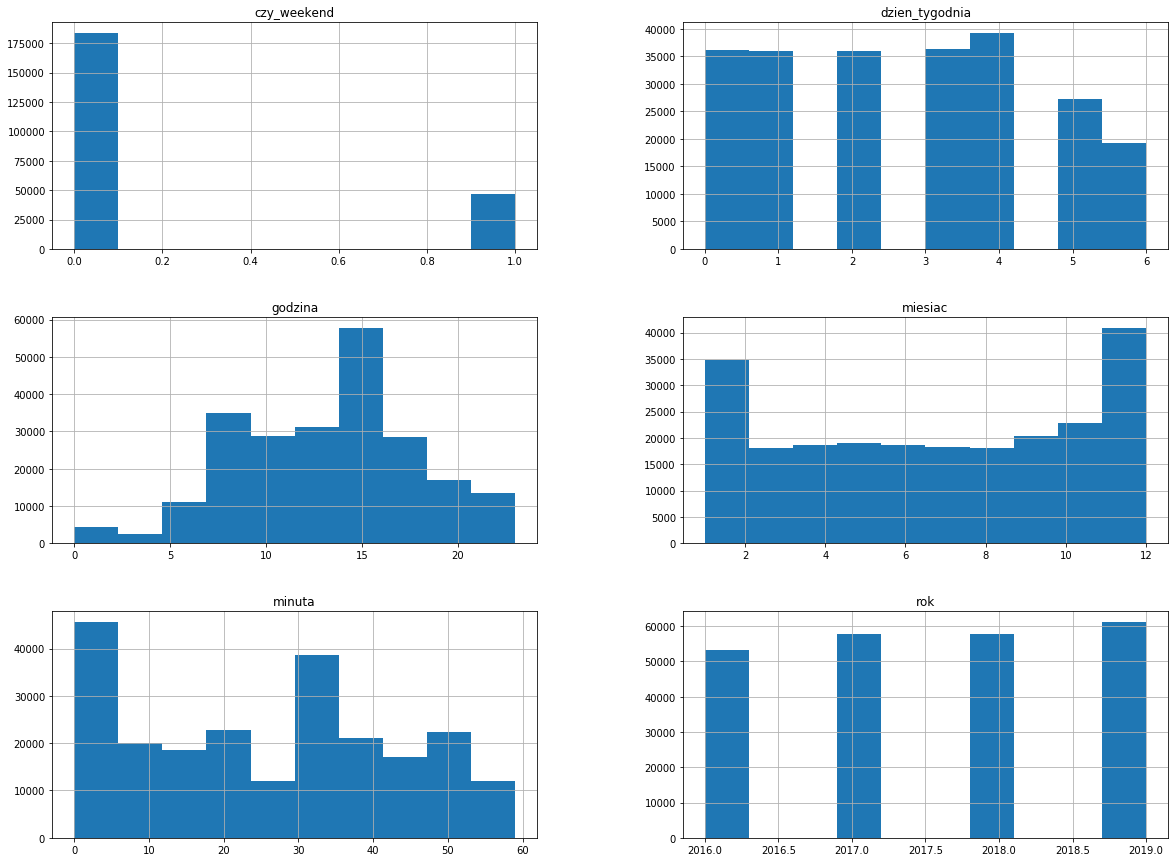

In [9]:
df[time_feats].hist(figsize=(20,15))
#plt.tight_layout()
plt.show()

### Współrzędne GPS

### Konwersja HH.MM.SS.S -> DD

In [10]:
# https://stackoverflow.com/questions/33997361
def dms2dd(coord):
    """ GPS HH.MM.SS.S to DD (Decimal Degrees) conversion """
    c = re.findall(r"\w+", coord)
    degrees = float(c[0])
    minutes = float(c[1])
    if len(c) > 2:
        seconds = float(c[2])/10   
    else:
        seconds = 0
    
    dd = float(degrees) + (minutes)/60 + float(seconds)/(60*60)

    return dd

df['lat'] = df['gps_y'].apply(lambda x : dms2dd(x)) # Latitude - N
df['lon'] = df['gps_x'].apply(lambda x : dms2dd(x)) # Longitude - E

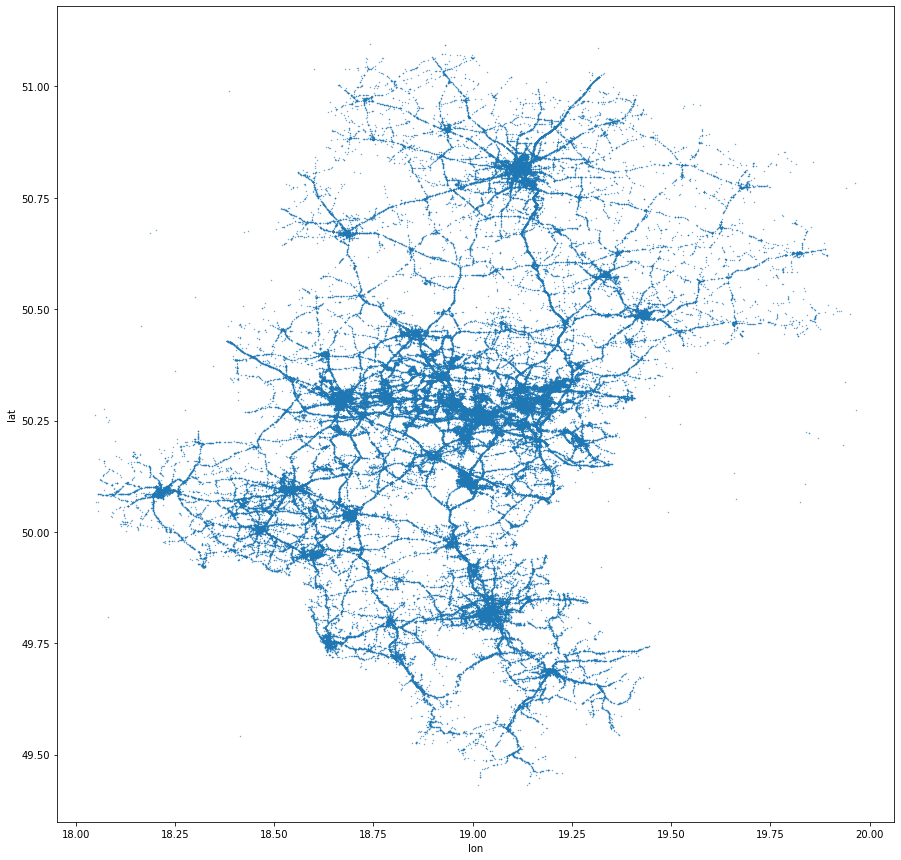

In [11]:
def plot_sca_map():
    dfmap = df.copy()

    dfmap.drop(dfmap[dfmap['lat'] < 49.393889].index, inplace=True)
    dfmap.drop(dfmap[dfmap['lat'] > 51.099167].index, inplace=True)
    dfmap.drop(dfmap[dfmap['lon'] < 18.035].index, inplace=True)
    dfmap.drop(dfmap[dfmap['lon'] > 19.973889].index, inplace=True)

    fig, ax = plt.subplots(figsize = (15, 15))
    dfmap.plot(kind='scatter', x='lon', y='lat', alpha=0.8, s=0.15, ax = ax)
    plt.show()
    
plot_sca_map()    

### Poprawa błędów

In [12]:
def clean_gps(x):
    s = re.sub(r"\d+",'', x)
    #print(s)
    return s

#clean_gps("50*15'068")
# prawidłowe formatowanie: *'
df['gps_err_y'] = df['gps_y'].apply(lambda x : clean_gps(x))
df['gps_err_x'] = df['gps_x'].apply(lambda x : clean_gps(x))

print('gps_err_y: ', df['gps_err_y'].unique(),'gps_err_x:',df['gps_err_x'].unique())

gps_err_y:  ["*'" "**'" "*'*" "*''"] gps_err_x: ["*'" "*''"]


In [13]:
feats = ["miejscowosc","ulica", "gps_x", "gps_x", "lat", "lon"]
df[feats][(df['gps_err_y']=="**'") | (df['gps_err_y']=="*'*") | (df['gps_err_y']=="*''") | (df['gps_err_x']=="*''")]

,miejscowosc,ulica,gps_x,gps_x,lat,lon
31931,WODZISŁAW ŚLĄSKI,ARMII KRAJOWEJ,18*28''05,18*28''05,50.013083,18.466806
135253,JASTRZĘBIE-ZDRÓJ,WIELKOPOLSKA,18*35'410,18*35'410,4.949139,18.594722
142857,JAWORZNO,NaN,19*15'220,19*15'220,50.150028,19.256111
149393,ŚWIĘTOCHŁOWICE,BYTOMSKA,18*55'084,18*55'084,50.300306,18.919000
161201,ZAWIERCIE,JÓZEFA PIŁSUDSKIEGO,19*25'274,19*25'274,50.417417,19.424278


In [14]:
nok_lst = [135253,161201]

#Manual Fix:
df.iloc[135253, df.columns.get_loc('gps_y')] = "49*56'569"
df['lat'] = df['gps_y'].apply(lambda x : dms2dd(x))

Współrzędne geograficzne skrajnych punktów:

    północny: 51°05′57″ szer. geogr. N – nurt Warty w pn.-wsch. narożniku działki ewidencyjnej nr 18/1 (powiat kłobucki),
    południowy: 49°23′38″ szer. geogr. N – słupek graniczny nr 161/6 (powiat żywiecki),
    zachodni: 18°02′06″ dług. geogr. E – słupek graniczny nr 45/5 (powiat raciborski),
    wschodni: 19°58′26″ dług. geogr. E – pn.-wsch. narożnik działki ewidencyjnej nr 124 (powiat zawierciański).

In [15]:
# bbox Silesian Voivodeship, Poland
#bbox = min Longitude , min Latitude , max Longitude , max Latitude 
#bbox = [18.035, 49.3939, 19.9741, 51.0995] - wg OSM

N = dms2dd("51°05′57")
S = dms2dd("49°23′38")
W = dms2dd("18°02′06")
E = dms2dd("19°58′26")

print(W,S,E,N)

bbox = [18.035, 49.3939, 19.9741, 51.0995] # wg OSM

feats = ["miejscowosc","ulica","numer_drogi", "gps_x", "gps_y","lat", "lon"]
df[feats][(df['lon'] < 18.035) | (df['lat'] < 49.3939) | (df['lon'] > 19.9741) | (df['lat'] > 51.0995)]

18.0335 49.384388888888886 19.967388888888888 51.08491666666667


,miejscowosc,ulica,numer_drogi,gps_x,gps_y,lat,lon
15349,KATOWICE,TRASA NIKODEMA I JÓZEFA RENCÓW,W902,19*59'033,50*16'087,50.269083,19.984250
20566,GLIWICE,LITERATÓW,I2,17*38'271,50*20'080,50.335556,17.640861
27105,OSINY,CZĘSTOCHOWSKA,791,19*23'227,51*33'157,51.554361,19.389639
32758,KONIECPOL,RYNEK,794,15*40'354,50*46'170,50.771389,15.676500
32880,ZABRZE,NaN,A4,21*59'567,50*20'277,50.341028,21.999083
34895,BONOWICE,NaN,78,16*46'322,50*37'081,50.618917,16.775611
37291,KATOWICE,NaN,A4,15*59'547,50*15'097,50.252694,15.998528
45271,KATOWICE,BRYNOWSKA,P6453S,19*59'452,50*14'025,50.234028,19.995889
49595,SKRZYDLÓW,GŁÓWNA,GMINNA,19*20'439,51*12'202,51.205611,19.345528
86014,MYKANÓW,NaN,1,19*20'260,50*90'457,51.512694,19.340556


In [95]:
fix_lst = df[(df['lon'] < 18.035) | (df['lat'] < 49.3939) | (df['lon'] > 19.9741) | (df['lat'] > 51.0995)].index.to_numpy()
print(fix_lst)

# CZĘSTOCHOWSKA, OSINY, silesian voivodeship, Poland
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Nominatim")

def geocode():
    columns = ['city', 'street','lat','lon', 'gps_x' ,'gps_y', 'geoloc_lat', 'geoloc_lon']
    df_ = pd.DataFrame(columns=columns)
    df_ = df_.fillna(0)

    for place in fix_lst:
        city = str(df.iloc[place].miejscowosc)
        street = str(df.iloc[place].ulica)
        lat =df.iloc[place].lat
        lon = df.iloc[place].lon
        gps_x = df.iloc[place]['gps_x']
        gps_y = df.iloc[place]['gps_y']
        if street.lower() == "nan":
            location = geolocator.geocode(f"{street},{city}, silesian voivodeship, Poland")
            print(f"{city}, silesian voivodeship, Poland")
        else:
            location = geolocator.geocode(f"{city}, silesian voivodeship, Poland")
            print(f"{street},{city}, silesian voivodeship, Poland")
        try:
            geoloc_lat = location.latitude
            geoloc_lon = location.longitude
            df_.loc[len(df_)] = [city, street, lat, lon, gps_x, gps_y, geoloc_lat, geoloc_lon]
        except:
            pass
            
        time.sleep(1)
    return df_

df_= geocode()
df_
# https://github.com/stemaan/infoshare_webinar

[ 15349  20566  27105  32758  32880  34895  37291  45271  49595  86014
 120955 122869 131415 134588 139483 145949 146928 147956 155437 160399
 161478 161915 162191 173479 203804]
TRASA NIKODEMA I JÓZEFA RENCÓW,KATOWICE, silesian voivodeship, Poland
LITERATÓW,GLIWICE, silesian voivodeship, Poland
CZĘSTOCHOWSKA,OSINY, silesian voivodeship, Poland
RYNEK,KONIECPOL, silesian voivodeship, Poland
ZABRZE, silesian voivodeship, Poland
BONOWICE, silesian voivodeship, Poland
KATOWICE, silesian voivodeship, Poland
BRYNOWSKA,KATOWICE, silesian voivodeship, Poland
GŁÓWNA,SKRZYDLÓW, silesian voivodeship, Poland
MYKANÓW, silesian voivodeship, Poland
ŚW. JANA PAWŁA II,DĄBROWA GÓRNICZA, silesian voivodeship, Poland
GRUNWALDZKA,JAWORZNO, silesian voivodeship, Poland
MYSŁOWICE, silesian voivodeship, Poland
WALENTEGO ROŹDZIEŃSKIEGO,KATOWICE, silesian voivodeship, Poland
JANA KOTUCZA,RYBNIK, silesian voivodeship, Poland
KOLEJOWA,KATOWICE, silesian voivodeship, Poland
CZĘSTOCHOWSKA,BLACHOWNIA, silesian voivo

,city,street,lat,lon,gps_x,gps_y,geoloc_lat,geoloc_lon
0,KATOWICE,TRASA NIKODEMA I JÓZEFA RENCÓW,50.269083,19.984250,19*59'033,50*16'087,50.259899,19.021585
1,GLIWICE,LITERATÓW,50.335556,17.640861,17*38'271,50*20'080,50.301131,18.662347
2,OSINY,CZĘSTOCHOWSKA,51.554361,19.389639,19*23'227,51*33'157,49.762807,18.774804
3,KONIECPOL,RYNEK,50.771389,15.676500,15*40'354,50*46'170,50.772529,19.676972
4,ZABRZE,nan,50.341028,21.999083,21*59'567,50*20'277,50.314281,18.781576
5,BONOWICE,nan,50.618917,16.775611,16*46'322,50*37'081,50.621902,19.773887
6,KATOWICE,nan,50.252694,15.998528,15*59'547,50*15'097,50.259899,19.021585
7,KATOWICE,BRYNOWSKA,50.234028,19.995889,19*59'452,50*14'025,50.259899,19.021585
8,SKRZYDLÓW,GŁÓWNA,51.205611,19.345528,19*20'439,51*12'202,50.856990,19.350060
9,MYKANÓW,nan,51.512694,19.340556,19*20'260,50*90'457,50.923320,19.199340


In [97]:
df_.to_csv(r'./data/geo_loc.csv', index = True)

In [16]:
df_=pd.read_csv('./data/geo_loc.csv')

df_.iloc[2, df_.columns.get_loc('geoloc_lat')] = 50.6916467
df_.iloc[2, df_.columns.get_loc('geoloc_lon')] = 19.1767317

df_['diff_lat'] = df_['lat']-df_['geoloc_lat']
df_['diff_lon'] = df_['lon']-df_['geoloc_lon']
df_

,Unnamed: 0,city,street,lat,lon,gps_x,gps_y,geoloc_lat,geoloc_lon,diff_lat,diff_lon
0,0,KATOWICE,TRASA NIKODEMA I JÓZEFA RENCÓW,50.269083,19.984250,19*59'033,50*16'087,50.259899,19.021585,0.009185,0.962665
1,1,GLIWICE,LITERATÓW,50.335556,17.640861,17*38'271,50*20'080,50.301131,18.662347,0.034424,-1.021486
2,2,OSINY,CZĘSTOCHOWSKA,51.554361,19.389639,19*23'227,51*33'157,50.691647,19.176732,0.862714,0.212907
3,3,KONIECPOL,RYNEK,50.771389,15.676500,15*40'354,50*46'170,50.772529,19.676972,-0.001141,-4.000472
4,4,ZABRZE,NaN,50.341028,21.999083,21*59'567,50*20'277,50.314281,18.781576,0.026747,3.217507
5,5,BONOWICE,NaN,50.618917,16.775611,16*46'322,50*37'081,50.621902,19.773887,-0.002986,-2.998276
6,6,KATOWICE,NaN,50.252694,15.998528,15*59'547,50*15'097,50.259899,19.021585,-0.007204,-3.023057
7,7,KATOWICE,BRYNOWSKA,50.234028,19.995889,19*59'452,50*14'025,50.259899,19.021585,-0.025871,0.974304
8,8,SKRZYDLÓW,GŁÓWNA,51.205611,19.345528,19*20'439,51*12'202,50.856990,19.350060,0.348621,-0.004532
9,9,MYKANÓW,NaN,51.512694,19.340556,19*20'260,50*90'457,50.923320,19.199340,0.589374,0.141216


In [17]:
def osm_url(i):
    diff_lat = round(df_.iloc[i].diff_lat,1)
    diff_lon = round(df_.iloc[i].diff_lon,1)
    print(i ,')',diff_lat, diff_lon)
    lat = df_.iloc[i].lat - diff_lat
    lon = df_.iloc[i].lon - diff_lon
    print(f"http://www.openstreetmap.org/?mlat={lat}&mlon={lon}&zoom=20&layers=M")

# 0 - ok : 0.0 1.0
# 1 - ok : 0.0 -1.0
# 2 - nok : 50.6916467 | 19.1767317
    #df.iloc[135253, df.columns.get_loc('lat')] = 50.6916467
    #df.iloc[135253, df.columns.get_loc('lon')] = 19.1767317
# 3 - ok: -0.0 -4.0
# 4 - nok: lat: 50.261027777777775



for item in range(25):     
    osm_url(item)

0 ) 0.0 1.0
http://www.openstreetmap.org/?mlat=50.26908333333333&mlon=18.98425&zoom=20&layers=M
1 ) 0.0 -1.0
http://www.openstreetmap.org/?mlat=50.335555555555565&mlon=18.64086111111111&zoom=20&layers=M
2 ) 0.9 0.2
http://www.openstreetmap.org/?mlat=50.65436111111111&mlon=19.18963888888889&zoom=20&layers=M
3 ) -0.0 -4.0
http://www.openstreetmap.org/?mlat=50.77138888888889&mlon=19.6765&zoom=20&layers=M
4 ) 0.0 3.2
http://www.openstreetmap.org/?mlat=50.341027777777775&mlon=18.799083333333332&zoom=20&layers=M
5 ) -0.0 -3.0
http://www.openstreetmap.org/?mlat=50.618916666666664&mlon=19.77561111111111&zoom=20&layers=M
6 ) -0.0 -3.0
http://www.openstreetmap.org/?mlat=50.25269444444446&mlon=18.998527777777774&zoom=20&layers=M
7 ) -0.0 1.0
http://www.openstreetmap.org/?mlat=50.234027777777776&mlon=18.995888888888892&zoom=20&layers=M
8 ) 0.3 -0.0
http://www.openstreetmap.org/?mlat=50.90561111111111&mlon=19.345527777777775&zoom=20&layers=M
9 ) 0.6 0.1
http://www.openstreetmap.org/?mlat=50.9126944

---

### Adres

In [28]:
print('kolumna Miejscowość : ', df['Miejscowość'].dtypes)
print('kolumna Ulica : ', df['Ulica'].dtypes)
print('kolumna Numer domu : ', df['Numer domu'].dtypes)
print('kolumna Numer drogi: ', df['Numer drogi'].dtypes)

kolumna Miejscowość :  object
kolumna Ulica :  object
kolumna Numer domu :  object
kolumna Numer drogi:  object


### Pikietaż

In [45]:
print('kolumna KM HM (Pikietaż): ', df['KM HM (Pikietaż)'].dtypes)
print('Przykładowe wartości z tej kolumny: ', df['KM HM (Pikietaż)'][df['KM HM (Pikietaż)'].notnull()].sample(3))

kolumna KM HM (Pikietaż):  float32
Przykładowe wartości z tej kolumny:  25776       0.500000
154697    515.000000
28757     548.599976
Name: KM HM (Pikietaż), dtype: float32


In [44]:
df['KM HM (Pikietaż)'] = df['KM HM (Pikietaż)'].apply(lambda x : str(x).replace(',','.'))
df['KM HM (Pikietaż)'] = df['KM HM (Pikietaż)'].astype(float)
df['KM HM (Pikietaż)'] = pd.to_numeric(df['KM HM (Pikietaż)'], downcast='float')

### Obszar

In [19]:
def area(x):
    if str(x) == 'Obszar zabudowany': return 1
    if str(x) == 'Obszar niezabudowany': return 0
    #if str(x) == 'nan': return 'nan'

print(df['obszar'].unique())
df['obszar'] = df['obszar'].apply(lambda x : area(x)) 

['Obszar niezabudowany' 'Obszar zabudowany' nan]


In [20]:
print(df['obszar'].unique())

[ 0.  1. nan]


### Skrzyżowanie

In [21]:
df['skrzyzowanie'].unique()

array([nan, 'Z drogą z pierwsz.', 'O ruchu okrężnym', 'Równorzędne'],
      dtype=object)

In [22]:
# 0 : O ruchu okrężnym | 1 : Równorzędne | 2 : Z drogą z pierwsz.
def crossing(x):
    if str(x) == 'O ruchu okrężnym': return 0
    if str(x) == 'Równorzędne': return 1
    if str(x) == 'Z drogą z pierwsz.': return 2
    if str(x) == 'nan': return -1

print(df['skrzyzowanie'].unique())
df['skrzyzowanie'] = df['skrzyzowanie'].apply(lambda x : crossing(x)) 

[nan 'Z drogą z pierwsz.' 'O ruchu okrężnym' 'Równorzędne']


In [23]:
print(df['skrzyzowanie'].unique())

[-1  2  0  1]


### Geometria drogi

In [24]:
df['geometria_drogi'].unique()

array(['Odcinek prosty', nan, 'Zakręt, łuk', 'Spadek', 'Wzniesienie',
       'Wierzchołek wzn.', 'Zakręt, łuk; Spadek',
       'Odcinek prosty; Spadek', 'Zakręt, łuk; Wzniesienie',
       'Odcinek prosty; Wzniesienie', 'Zakręt, łuk; Wierzchołek wzn.',
       'Odcinek prosty; Wierzchołek wzn.', 'Odcinek prosty; Zakręt, łuk'],
      dtype=object)

In [25]:
df['charakterystyka_miejsca_zdarzenia'].unique()

array(['Jezdnia', 'Chodnik, droga dla pieszych', 'Parking, plac',
       'Wjazd, wyjazd z posesji, pola', 'Parking, plac, MOP (od 11.2015)',
       'Skarpa, rów', 'Pobocze', 'Przejście dla pieszych',
       'Most, wiadukt, łącznica, tunel', 'Pas dzielący jezdnie',
       'Przejazd kolejowy strzeżony', 'Przejazd tramwajowy, torowisko',
       'Przystanek komunikacji publicznej', 'Droga dla rowerzystów',
       'Przejazd kolejowy niestrzeżony',
       'Roboty drogowe, oznakowanie tymczasowe',
       'Droga, pas ruchu, śluza dla rowerów (od 11.2015)',
       'Przejazd dla rowerzystów (od 11.2015)',
       'Przewiązka na drodze dwujezdniowej', 'Parking, plac, MOP',
       'Przejazd tramwajowy, torowisko tramwajowe',
       'Droga, pas ruchu, śluza dla rowerów', 'Przejazd dla rowerzystów',
       nan], dtype=object)

In [26]:
df['oswietlenie'].unique()
## TODO: Dzień  / NOC / Oswietlona

array(['Noc - droga nieoświetlona', 'Noc - droga oświetlona',
       'Światło dzienne', 'Zmrok, świt', 'Świt, zmrok'], dtype=object)

In [32]:
df['warunki_atmosferyczne'].unique()

array(['Dobre warunki atmosferyczne', 'Pochmurno', 'Mgła, dym',
       'Oślepiające słońce', 'Opady śniegu, gradu',
       'Pochmurno; Opady śniegu, gradu', 'Opady deszczu',
       'Opady deszczu; Opady śniegu, gradu', 'Pochmurno; Opady deszczu',
       'Pochmurno; Mgła, dym', 'Pochmurno; Opady deszczu; Mgła, dym',
       'Opady deszczu; Mgła, dym',
       'Pochmurno; Opady deszczu; Opady śniegu, gradu',
       'Silny wiatr; Pochmurno; Opady śniegu, gradu',
       'Pochmurno; Opady śniegu, gradu; Mgła, dym',
       'Opady śniegu, gradu; Mgła, dym', 'Silny wiatr',
       'Silny wiatr; Opady deszczu', 'Silny wiatr; Pochmurno',
       'Silny wiatr; Opady śniegu, gradu',
       'Oślepiające słońce; Silny wiatr',
       'Silny wiatr; Pochmurno; Opady deszczu',
       'Oślepiające słońce; Opady deszczu', nan,
       'Silny wiatr; Opady deszczu; Opady śniegu, gradu',
       'Silny wiatr; Pochmurno; Opady deszczu; Opady śniegu, gradu',
       'Opady deszczu; Opady śniegu, gradu; Mgła, dym'], d

In [33]:
df['rodzaj_zdarzenia'].unique()

array(['Najechanie na zwierzę', 'Najechanie na pojazd unieruchomiony',
       'Zderzenie pojazdów tylne', 'Najechanie na słup, znak',
       'Zderzenie pojazdów boczne', 'Najechanie na barierę ochronną',
       'Inne', 'Najechanie na dziurę, wybój, garb',
       'Najechanie na pieszego', 'Wywrócenie się pojazdu',
       'Zderzenie pojazdów czołowe', 'Najechanie na drzewo',
       'Najechanie na zapore kolejową', 'Zdarzenie z pasażerem'],
      dtype=object)

In [34]:
df['wina'].unique()

array(['z innych przyczyn', 'z winy kierującego',
       'współwina uczestników ruchu', 'z winy pieszego'], dtype=object)

In [35]:
df['rodzaj_drogi'].unique()

array(['Jednojezdniowa dwukierunkowa', 'Jednokierunkowa', 'Autostrada',
       'Dwie jezdnie jednokierunkowe', 'Ekspresowa', nan], dtype=object)

In [36]:
df['nawierzchnia_drogi'].unique()

array(['Twarda', 'Gruntowa', nan], dtype=object)

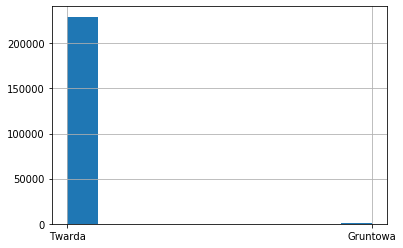

In [46]:
df['nawierzchnia_drogi'].hist()

In [47]:
df['stan_nawierzchni'].unique()

array(['Sucha', 'Mokra', 'Oblodzona, zaśnieżona',
       'Mokra; Oblodzona, zaśnieżona', 'Koleiny, garby',
       'Zanieczyszczona', 'Mokra; Koleiny, garby',
       'Oblodzona, zaśnieżona; Dziury, wyboje', 'Mokra; Dziury, wyboje',
       'Kałuże, rozlewiska', 'Kałuże, rozlewiska; Oblodzona, zaśnieżona',
       'Mokra; Kałuże, rozlewiska', 'Zanieczyszczona; Dziury, wyboje',
       'Dziury, wyboje', 'Mokra; Kałuże, rozlewiska; Dziury, wyboje',
       'Sucha; Dziury, wyboje', 'Sucha; Zanieczyszczona',
       'Mokra; Kałuże, rozlewiska; Koleiny, garby',
       'Mokra; Zanieczyszczona',
       'Mokra; Zanieczyszczona; Koleiny, garby; Dziury, wyboje',
       'Mokra; Kałuże, rozlewiska; Oblodzona, zaśnieżona',
       'Mokra; Koleiny, garby; Dziury, wyboje',
       'Kałuże, rozlewiska; Dziury, wyboje',
       'Oblodzona, zaśnieżona; Zanieczyszczona; Koleiny, garby; Dziury, wyboje',
       'Zanieczyszczona; Koleiny, garby; Dziury, wyboje',
       'Mokra; Kałuże, rozlewiska; Zanieczyszczona; Kol

In [48]:
df['sygnalizacja_swietlna'].unique()

array(['Brak', 'Jest, nie działa', 'Jest, działa'], dtype=object)

In [ ]:
#stwórzmy dodatkową kolumnę sygnalizacja_dziala
#df['sygnalizacja_dziala'] =  

#zamieńmy wartości na zmienne 0 i 1 (sygnalizacja jest/nie ma)

In [50]:
df['liczba_pasow_w_zdarzeniu'].unique()

array([  2.,  nan,   1.,   3.,   4.,   5.,   6.,   8.,   7.,   0.,   9.,
       250.,  50.,  24.,  90.,  12.,  60.,  20.,  70.,  40.,  18.,  13.,
        10.,  14.,  17.,  66.,  11.,  16.,  25.,  22.,  32.,  30.,  67.,
        15.])

In [51]:
df['zachowanie_kierujacego'].unique()

array([nan, 'Nieprawidłowe: cofanie', 'Nieprawidłowe: omijanie',
       'Niedostosowanie prędkości do warunków ruchu',
       'Nieudzielenie pierwszeństwa przejazdu',
       'Inne przyczyny (od 11.2015)',
       'Niezachowanie bezp. odl. między pojazdami',
       'Nieprawidłowe: skręcanie', 'Nieprawidłowe: zmienianie pasa ruchu',
       'Zmęczenie, zaśnięcie', 'Nieprawidłowe: wymijanie',
       'Nieprzestrzeganie innych sygnałów',
       'Niestosowanie się do sygnalizacji świetlnej (od 11.2015)',
       'Nieustąpienie pierwszeństwa pieszemu na przejściu dla pieszych (od 11.2015)',
       'Gwałtowne hamowanie', 'Nieprawidłowe: wyprzedzanie',
       'Nieprawidłowe: zatrzymywanie, postój',
       'Nieprawidłowe: wymijanie; Nieprawidłowe: wymijanie',
       'Nieprawidłowe: cofanie; Nieprawidłowe: cofanie',
       'Nieprawidłowe: Zawracanie',
       'Nieprawidłowe: skręcanie; Nieprawidłowe: skręcanie',
       'Nieustąpienie pierwszeństwa pieszemu w innych okolicznościach (od 11.2015)',
    

In [52]:
df['zachowanie_pieszego'].unique()

array([nan, 'Wejście na jezdnię przy czerwonym świetle',
       'Przekraczanie jezdni w miejscu niedozwolonym',
       'Nieostrożne wejście na jezdnię: przed jadącym pojazdem',
       'Inne przyczyny (od 11.2015)',
       'Nieostrożne wejście na jezdnię: zza pojazdu, przeszkody',
       'Chodzenie nieprawidłową stroną drogi',
       'Stanie na jezdni, leżenie',
       'Nieostrożne wejście na jezdnię: przed jadącym pojazdem; Nieostrożne wejście na jezdnię: przed jadącym pojazdem',
       'Zatrzymanie, cofnięcie się',
       'Przekraczanie jezdni w miejscu niedozwolonym; Przekraczanie jezdni w miejscu niedozwolonym',
       'Inne przyczyny',
       'Leżenie, siedzenie, klęczenie, stanie na jezdni',
       'Nieostrożne wejście na jezdnię: zza pojazdu, przeszkody; Nieostrożne wejście na jezdnię: zza pojazdu, przeszkody',
       'Wejście na jezdnię przy czerwonym świetle; Wejście na jezdnię przy czerwonym świetle',
       'Inne przyczyny; Inne przyczyny',
       'Chodzenie nieprawidłową str

In [53]:
df['inne_przyczyny'].unique()

array(['Obiekty, zwierzęta na drodze', nan, 'Nieustalone',
       'Niewłaściwy stan jezdni', 'Inne',
       'Utrata przytomności, śmierć kierującego (od 11.2015)',
       'Pożar pojazdu', 'Nieprawidłowo zabezp. roboty drogowe',
       'Niesprawność techniczna pojazdu (od 11.2015)', 'Z winy pasażera',
       'Oślepienie przez inny pojazd lub słońce',
       'Nieprawidłowo działająca zapora, rogatka', 'Stan jezdni',
       'Niesprawność techniczna pojazdu',
       'Zabezpieczenie robót na drodze',
       'Utrata przytomności, śmierć kierującego', 'Organizacja ruchu',
       'Nieprawidłowo działająca zapora kolej.',
       'Działanie sygnalizacji świetlnej'], dtype=object)

In [54]:
print(df['liczba_rannych_w_zdarzeniu'].unique())
df['ranni'] = df['liczba_rannych_w_zdarzeniu']

[ 0  4  1  2  3  6  5  9 11  8 26  7 10 12]


In [78]:
print(df['Liczba zabitych w zdarzeniu'].unique())
df['zabici'] = df['Liczba zabitych w zdarzeniu']

[0 1 2 4 3]


In [80]:
print(df['Liczba kolizji'].unique())
df['kolizje'] = df['Liczba kolizji']

[1 0]


In [81]:
print(df['Liczba wypadków'].unique())
df['wypadki'] = df['Liczba wypadków']

[0 1]


In [82]:
#df.fillna(-1)

- W jakm mieście na śląsku jest najwięcej wypadków.
- Liczba wypadków na 1000 mieszkańców.
- Rozkład wypadków w czasie (dzień, mc, dzień tygodnia).
- Korelacja wypadków z fazą księżyca.
- W jakich miejscach jest najwięcej wypadków.
- Powody wypadków, a dzień lub godzina
- Wyciągnąć z OSM wypadki pieszych, czy w pobliżu były pasy dla pieszych.
- Korelacja wypadków z otaczającym terenem.
- Korelacja wypadków z gęstością zaludnienia.
- Korelacja wypadków z odległością od centrum.
- Korelacja wypadków z odległością od przystanków.
- Korelacja obszaru z ilością wypadków.
- Korelacja wypadków z ograniczeniami prędkości.
- Porównanie strefy 30 vs bez strefy.
- Porównanie wypadków na przejściach z dozwoloną prędkością.
- Warunki pogodowe vs wypadki.
- Zmiana czasu (lato\zima), a wypadki.
- Wypłata pensji (data),a wypadki na drodze.
- Czy nagła zmiana temperatury miała wpływ na ilość wypadków